In [ ]:
# @title Multi-Frame Vortex Spacing Statistics

n_process = min(n_frames, 50)   # frames to analyse — increase for better stats
U_conv = conv_factor * U_inf

all_spacings_m = []
all_freqs      = []

for i in range(n_process):
    U_i, V_i, mask_i = load_frame(frames, i)
    _, lamci_i, _, _ = compute_fields(U_i, V_i, mask_i, dx_m, dy_m)
    cx_i, cy_i, _    = detect_cores(lamci_i, x_xc, y_xc)

    if len(cx_i) >= 2:
        order = np.argsort(cx_i)
        sp = np.sqrt(np.diff(cx_i[order])**2 +
                     np.diff(cy_i[order])**2) * c       # metres
        all_spacings_m.extend(sp)
        all_freqs.extend(U_conv / sp)

    if (i + 1) % 10 == 0:
        print(f"  processed {i+1}/{n_process} frames  "
              f"({len(all_spacings_m)} spacings so far)")

all_spacings_m = np.array(all_spacings_m)
all_freqs      = np.array(all_freqs)

print(f"\nTotal inter-core spacings collected: {len(all_spacings_m)}")
if len(all_spacings_m) > 0:
    print(f"Spacing — mean: {np.mean(all_spacings_m)*1000:.2f} mm,  "
          f"std: {np.std(all_spacings_m)*1000:.2f} mm")
    print(f"Frequency — mean: {np.mean(all_freqs):.0f} Hz,  "
          f"std: {np.std(all_freqs):.0f} Hz")

    # ── Histograms ──
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4),
                                   constrained_layout=True)

    ax1.hist(all_spacings_m * 1000, bins=30, edgecolor='k')
    ax1.axvline(np.mean(all_spacings_m)*1000, c='r', ls='--',
                label=f'mean = {np.mean(all_spacings_m)*1000:.1f} mm')
    ax1.set_xlabel('Spacing (mm)'); ax1.set_ylabel('Count')
    ax1.set_title('Vortex-core spacing distribution')
    ax1.legend()

    ax2.hist(all_freqs, bins=30, edgecolor='k')
    ax2.axvline(np.mean(all_freqs), c='r', ls='--',
                label=f'mean = {np.mean(all_freqs):.0f} Hz')
    ax2.set_xlabel('Frequency (Hz)'); ax2.set_ylabel('Count')
    ax2.set_title('Estimated vortex-shedding frequency')
    ax2.legend()

    plt.show()
else:
    print("No spacings collected — check detection parameters")


<a href="https://colab.research.google.com/github/gjardim27/GuilhermeJardimPortfolio/blob/main/Gui_Process_PIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replace 0 values in velocity arrays with nans

if that doesn't fix it, determine theta bounds

replace circle fit with curve_fit call

fix scale factor


In [1]:
# @title Setup

# Install packages with pip
# %pip install pint
%pip install pyfluids
# %pip install scipy
%pip install lvpyio==1.3.1


# @title Import dependencies
import gspread
import google.colab, google.auth
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.lines
import matplotlib
import numpy as np
import os
import pandas as pd
import lvpyio as lv
import pyfluids
import datetime
import time
import scipy
import yaml
import scipy.optimize
import scipy.interpolate

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


# Mount google drive (must be separate cell to avoid re-mounting errors)
# allows reading of text/.csv files from google drive, but NOT google sheets files.
force_remount = False # @param {type:"boolean"}
drive.mount('/content/drive', force_remount=force_remount)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.4 MB/s eta 0:00:00
Mounted at /content/drive


# PIV Perturbation Analysis

Scale is 0.019744 mm / box


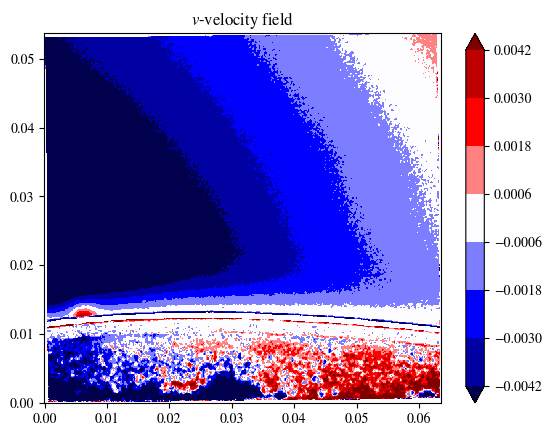

In [ ]:
# @title Load PIV

# Name of directory containing PIV data
piv_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/PIV/N65_WT_PIV_Flow_Fields"
mi_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/Model Installation/InstallationRunFolders"

# name of lavision project containing PIV data
project_run = 1387
project = f"CJK_NACA651412_RUN{project_run}"

project_path = os.path.join(piv_root, project)

# photo directory
photo_dir = os.path.join(mi_root, f"Run{project_run}")

c = 0.2

# Run number for processed PIV
run = 1414 # @param {type: "integer"}
#identify folder corresponding to run (regardless of TP number)
run_dir = next(f for f in os.listdir(project_path) if f.startswith(f"RUN{run}") and not f.endswith(".set"))

run_path = os.path.join(project_path, run_dir)

inst_piv_path = os.path.join(run_path, "PIV_MP(3x8x8_50%ov_ImgCorr)")
avgd_piv_path = os.path.join(inst_piv_path, "Avg_Stdev")
u_lim = 4.2e-3

piv_avg_b, piv_std_b = lv.read_set(avgd_piv_path)  # set has 2 buffers

scale = piv_avg_b[0].scales.x.slope
scale_unit = piv_avg_b[0].scales.x.unit
print(f"Scale is {scale} {scale_unit} / box")

piv_avg = piv_avg_b.as_masked_array()
mask = piv_avg.mask["u"][::-1,::-1]
u = piv_avg.data["u"][::-1,::-1]
v = piv_avg.data["v"][::-1,::-1]
# *scale converts to mm, *1000 to m, and /c to x/c
x = np.arange(u.shape[1])*scale/1000/c
y = np.arange(u.shape[0])*scale/1000/c
X, Y = np.meshgrid(x, y)

ticks = np.linspace(-u_lim, u_lim, 8, endpoint=True)
cmap = plt.colormaps['seismic']
norm = matplotlib.colors.BoundaryNorm(
    boundaries=ticks,
    ncolors=256,
    extend='both',
)

plt.pcolormesh(X, Y, v, cmap=cmap, norm=norm)
plt.colorbar(ticks=ticks)
plt.title('$v$-velocity field')

plt.show()


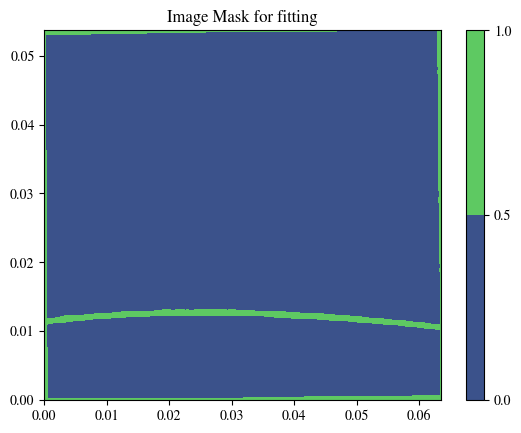

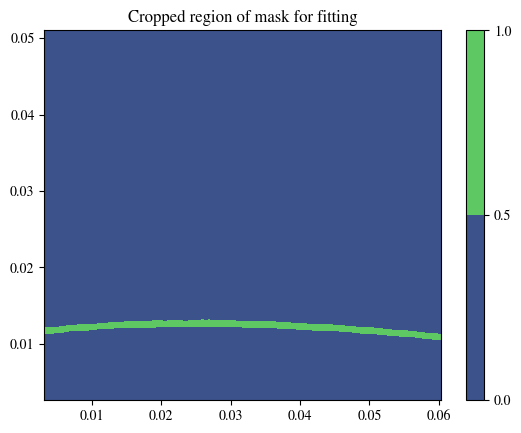

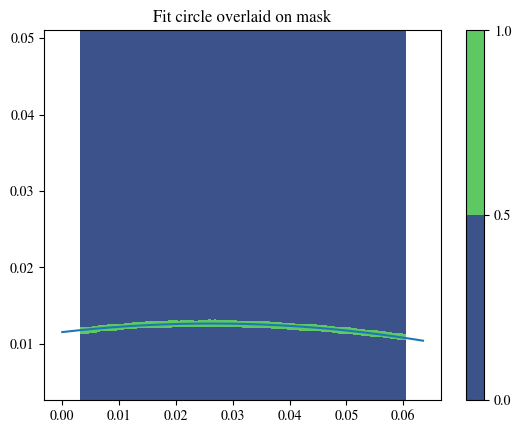

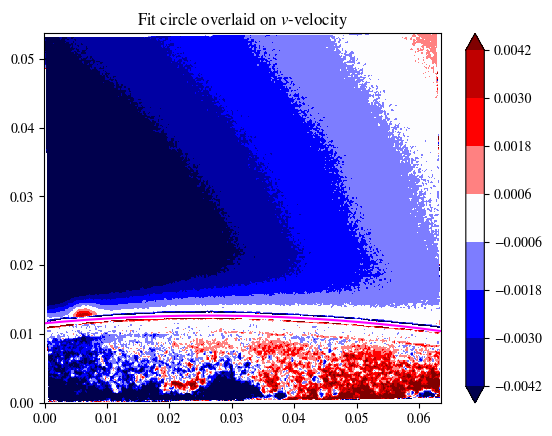

In [ ]:
# @title fit circle
plt.contourf(X, Y, mask)
plt.colorbar()
plt.title("Image Mask for fitting")
plt.show()

fit_region_prop = 0.9 # @param {type:"number"}
edge_prop = (1-fit_region_prop)/2
x_sz = len(x)
y_sz = len(y)
ix_min = int(edge_prop*x_sz)
iy_min = int(edge_prop*y_sz)
x_fit = x[ix_min:-ix_min]
y_fit = y[iy_min:-iy_min]
mask_fit = mask[iy_min:-iy_min,ix_min:-ix_min]
X_fit, Y_fit = np.meshgrid(x_fit, y_fit)

plt.contourf(X_fit, Y_fit, mask_fit)
plt.colorbar()
plt.title("Cropped region of mask for fitting")
plt.show()

def circle_to_fit(xc, yc, r, xp, yp, mask):
    """
    fit a circle to a set of points
    input arguments:
    xc: scalar x coordinate of center (to be fit)
    yc: scalar y coordinate of center (to be fit)
    r: scalar radius of circle (to be fit)
    xp: ndarray of x values of data points
    yp: ndarray of y values of data points
    """
    score = 0
    n, m = xp.shape
    for i in range(n):
        for j in range(m):
            x = xp[i,j]
            y = yp[i,j]
            if mask[i,j]:
                score += (np.sqrt((x-xc)**2 + (y-yc)**2) - r)**2
    score = np.sqrt(score)
    return score


minimization_function = lambda p: circle_to_fit(p[0], p[1], p[2], X_fit, Y_fit, mask_fit)
d_grid = np.sqrt((np.max(x)-np.min(x))**2 + (np.max(y)-np.min(y))**2)  # diameter (diagonal) of image
p0 = (0, 0, d_grid)
res = scipy.optimize.minimize(minimization_function, p0).x
xc, yc, r = res
circle = lambda x: yc + np.sqrt(r**2 - (x-xc)**2)

plt.plot(x, circle(x))
plt.contourf(X_fit, Y_fit, mask_fit)
plt.colorbar()
plt.title("Fit circle overlaid on mask")
plt.show()

plt.plot(x, circle(x), c='magenta')
plt.pcolormesh(X, Y, v, cmap=cmap, norm=norm)
plt.colorbar(ticks=ticks)
plt.title("Fit circle overlaid on $v$-velocity")
plt.show()




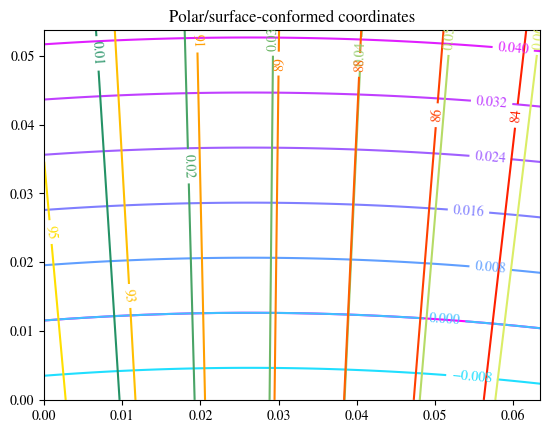

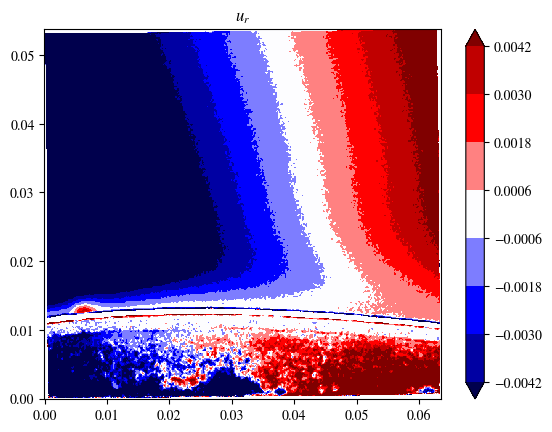

In [ ]:
# @title Convert to surface-conformed coordinates
X_shifted = X - xc
Y_shifted = Y - yc

rho = np.sqrt(X_shifted**2 + Y_shifted**2) - r
theta = np.arctan2(Y_shifted, X_shifted)

theta2xi = lambda phi:  r*(np.max(theta) - phi)
xi2theta = lambda xi: np.max(theta) - xi/r

xi = theta2xi(theta)

ur = (u*X_shifted+v*Y_shifted)/(rho+r)

plt.plot(x, circle(x), c='magenta')

rho_cs = plt.contour(X, Y, rho, cmap="cool")
plt.clabel(rho_cs, rho_cs.levels)

xi_cs = plt.contour(X, Y, xi, cmap="summer")
plt.clabel(xi_cs, xi_cs.levels)

theta_cs = plt.contour(X, Y, theta, cmap="autumn")
plt.clabel(theta_cs, theta_cs.levels, fmt=lambda phi: f"{np.rad2deg(phi):0.0f}")

plt.title("Polar/surface-conformed coordinates")
plt.show()

plt.title("$u_r$")
urc = plt.pcolormesh(X, Y, ur, cmap=cmap, norm=norm)
plt.colorbar(urc, ticks=ticks)
plt.show()



a: 3.93e-03, xbar: 6.37e-03, sigma: 1.17e-03
a: 2.27e-03, xbar: 6.41e-03, sigma: 1.55e-03
a: 1.50e-03, xbar: 6.45e-03, sigma: 1.84e-03
a: 9.39e-04, xbar: 6.50e-03, sigma: 2.18e-03
a: 4.49e-04, xbar: 7.32e-03, sigma: 1.97e-03


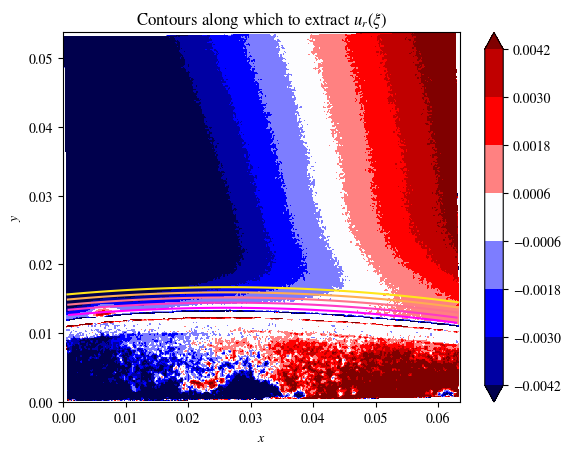

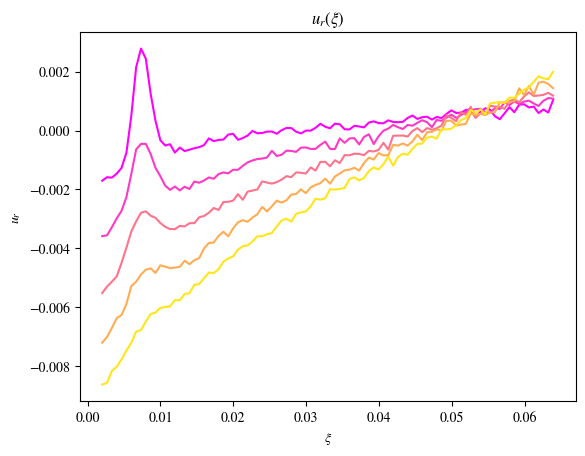

In [ ]:
# @title Plot $u_r(\xi)$ for various $\eta$

# define ur for interpolation
ur_cmap = matplotlib.colormaps['spring']
ur_interp = scipy.interpolate.RegularGridInterpolator((x, y), ur.T, fill_value=np.nan, bounds_error=False)

maxtheta = xi2theta(np.min(xi))
theta_arr = np.linspace(np.min(theta), maxtheta, 100)
# theta_arr = theta_arr[3:-4]
theta_deg_arr = np.rad2deg(theta_arr)
etavalues = np.linspace(10e-4, 40e-4, 5)

def color(eta):
    # put eta between 0 and 1
    eta_scaled = (eta-np.min(etavalues))/(np.max(etavalues)-np.min(etavalues))
    # remove last 10% which is too yellow
    eta_scaled = eta_scaled*0.9
    return ur_cmap(eta_scaled)

xwid_fig_ur_xi = 0.03

# fit Gaussian of amplitude a, mean mu, and std sigma summed with 2nd order polynomial
ur_curve = lambda x, a, mu, sigma, b, m, q, c: a*np.exp(-(x-mu)**2/(2*sigma**2)) + b + m*x + q*x**2 + c*x**3

plt.figure(2)
plt.title(r"$u_r(\xi)$")
plt.xlabel(r"$\xi$")
plt.ylabel("$u_r$")
# plt.xlim(0, xwid_fig_ur_xi)

plt.figure(1)
plt.pcolormesh(X, Y, ur, cmap=cmap, norm=norm)
plt.colorbar(ticks=ticks)
plt.title(r"Contours along which to extract $u_r(\xi)$")
y_0fig_ur_xi = 0.005
# plt.xlim(0, xwid_fig_ur_xi)
# plt.ylim(y_0fig_ur_xi, y_0fig_ur_xi+xwid_fig_ur_xi)
plt.xlabel("$x$")
plt.ylabel("$y$")
for eta in etavalues:
    r_eta = eta + r

    x_arr, y_arr = r_eta*np.cos(theta_arr)+xc, r_eta*np.sin(theta_arr)+yc
    xi_arr = theta2xi(theta_arr)
    ur_arr = ur_interp((x_arr, y_arr))

    # remove nans aand 0s from arrays
    good_indices = np.logical_and(np.logical_not(np.isnan(ur_arr)), ur_arr != 0)
    x_arr = x_arr[good_indices]
    y_arr = y_arr[good_indices]
    xi_arr = xi_arr[good_indices]
    ur_arr = ur_arr[good_indices]

    urpopt, urpcov = scipy.optimize.curve_fit(ur_curve, x_arr[1:-2], ur_arr[1:-2], (0.006, 0.007, 0.001, -0.004, 0.11, -0.5, 0))
    a_fit, mu_fit, sigma_fit, b_fit, m_fit, q_fit, c_fit = urpopt
    if mu_fit < np.min(x_arr):
        a_fit = 0
        sigma_fit = np.nan
        xbar = np.nan
    ur_curve_fit = lambda x: ur_curve(x, a_fit, mu_fit, sigma_fit, b_fit, m_fit, q_fit, c_fit)

    plt.figure(1)  # contours overlaid on ur
    plt.plot(x_arr, y_arr, "-", c=color(eta))

    plt.figure(2)  # ur(xi)
    plt.plot(xi_arr, ur_arr, "-", c=color(eta))
    # plt.plot(xi_arr, ur_curve_fit(x_arr), '--', c=color(eta))
    print(f'a: {a_fit:1.2e}, xbar: {mu_fit:1.2e}, sigma: {sigma_fit:1.2e}')


plt.show()


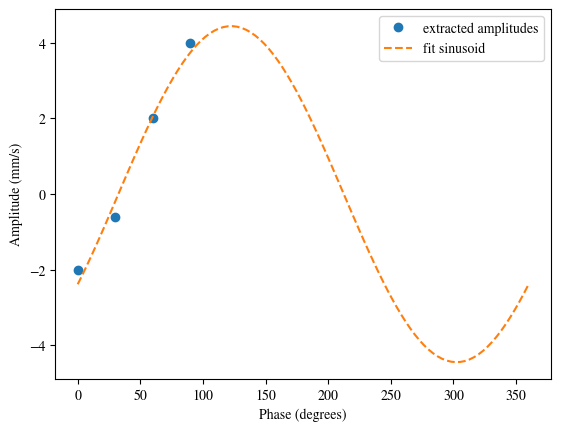

4.44e+00


In [ ]:
phase_scr = np.linspace(90, 0, 4)
amps_scr = np.array([4, 2, -0.6, -2])  # 240 Hz
# amps_scr = np.array([0.6, 0.9, 1, 1])  # 30  Hz


plotting_phases = np.linspace(0, 360, 100)

sin_fit_params = lambda x, a_sin, phi_sin: a_sin*np.sin(2*np.pi*x/360+phi_sin)

sin_popt = scipy.optimize.curve_fit(sin_fit_params, phase_scr, amps_scr)
a_sin_fit, phi_sin_fit = sin_popt[0]

sin_fit = lambda x: sin_fit_params(x, a_sin_fit, phi_sin_fit)

plt.plot(phase_scr, amps_scr, 'o', label="extracted amplitudes")
plt.plot(plotting_phases, sin_fit(plotting_phases), "--", label="fit sinusoid")
plt.xlabel("Phase (degrees)")
plt.ylabel("Amplitude (mm/s)")
plt.legend()
plt.show()

print(f"{a_sin_fit:1.2e}")

In [ ]:
# @title Vorticity Identification from Instantaneous PIV (Corrected)

import scipy.ndimage

# ── Data Loading ──
piv_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/PIV/N65_WT_PIV_Flow_Fields"
mi_root  = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/Model Installation/InstallationRunFolders"

project_run = 1117
project = f"CJK_NACA651412_RUN{project_run}"
project_path = os.path.join(piv_root, project)
photo_dir = os.path.join(mi_root, f"Run{project_run}")

c = 0.2  # chord length [m]
run = 1178  # @param {type: "integer"}
run_dir = next(f for f in os.listdir(project_path)
               if f.startswith(f"RUN{run}") and not f.endswith(".set"))
run_path = os.path.join(project_path, run_dir)

print("Files in run_path:")
for f in os.listdir(run_path):
    print(f)

inst_piv_path = os.path.join(run_path, "PIV_MP(3x16x16_50%ov_ImgCorr)")

# Load all instantaneous frames
buffer = lv.read_set(inst_piv_path)
frames = buffer[0]
n_frames = len(frames)
print(f"\nLoaded {n_frames} instantaneous PIV frames")

scale = frames[0].scales.x.slope   # mm/box
unit  = frames[0].scales.x.unit
print(f"Scale: {scale} {unit}/box")


# ── Helper: load one frame ──
def load_frame(frames, idx):
    """Return U, V [m/s] and mask for frame *idx*."""
    piv  = frames[idx].as_masked_array()
    mask = piv.mask["u"][::-1, ::-1]
    U    = piv.data["u"][::-1, ::-1].astype(float) / 1000   # mm/s -> m/s
    V    = piv.data["v"][::-1, ::-1].astype(float) / 1000
    U[mask] = np.nan
    V[mask] = np.nan
    return U, V, mask


# ── Physical grid (metres) for correct gradient units ──
U0, V0, mask0 = load_frame(frames, 0)
dx_m = scale / 1000          # mm -> m per grid point
dy_m = scale / 1000
x_m  = np.arange(U0.shape[1]) * dx_m
y_m  = np.arange(U0.shape[0]) * dy_m

# x/c grid for plotting
x_xc = x_m / c
y_xc = y_m / c
X_xc, Y_xc = np.meshgrid(x_xc, y_xc)


# ── Normalised Gaussian smoothing (handles masked regions) ──
def smooth_masked(F, mask, sigma):
    """Gaussian smooth with normalised convolution so masked pixels
    don't bleed zeros into valid data."""
    F_fill = np.where(mask, 0.0, np.nan_to_num(F))
    W      = (~mask).astype(float)
    F_s = scipy.ndimage.gaussian_filter(F_fill, sigma=sigma)
    W_s = scipy.ndimage.gaussian_filter(W,      sigma=sigma)
    W_s[W_s < 1e-10] = np.nan
    return F_s / W_s


# ── Compute all derived fields for one snapshot ──
sigma_smooth = 1.5   # Gaussian kernel width in grid points — tune as needed

def compute_fields(U, V, mask, dx, dy, sigma=sigma_smooth):
    """Return omega_z, lamci, Q, expanded_mask."""
    U_s = smooth_masked(U, mask, sigma)
    V_s = smooth_masked(V, mask, sigma)

    dU_dy, dU_dx = np.gradient(U_s, dy, dx)
    dV_dy, dV_dx = np.gradient(V_s, dy, dx)

    # Expand mask by 2 px to discard boundary artefacts
    exp_mask = scipy.ndimage.binary_dilation(mask, iterations=2)
    for g in (dU_dx, dU_dy, dV_dx, dV_dy):
        g[exp_mask] = np.nan

    # ── Spanwise vorticity ──
    omega_z = dV_dx - dU_dy

    # ── Velocity-gradient tensor eigenvalue analysis ──
    #   A = [[dU/dx, dU/dy],
    #        [dV/dx, dV/dy]]
    # FIX: trace = diagonal sum, not off-diagonal
    tr   = dU_dx + dV_dy
    det  = dU_dx * dV_dy - dU_dy * dV_dx
    disc = tr**2 - 4.0 * det

    # Swirling strength = |Im(eigenvalue)| where disc < 0
    lamci = np.zeros_like(U)
    cpx = disc < 0.0
    lamci[cpx] = 0.5 * np.sqrt(-disc[cpx])
    lamci[exp_mask] = np.nan

    # ── Q-criterion ──
    sxy = 0.5 * (dU_dy + dV_dx)
    S2  = dU_dx**2 + dV_dy**2 + 2.0 * sxy**2
    Om2 = 0.5 * omega_z**2
    Q   = 0.5 * (Om2 - S2)
    Q[exp_mask] = np.nan

    return omega_z, lamci, Q, exp_mask


omega_z, lamci, Q, exp_mask = compute_fields(U0, V0, mask0, dx_m, dy_m)


# ── Visualisation with proper colour limits ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# V-velocity
u_lim = 4.2e-3
im0 = axes[0,0].pcolormesh(X_xc, Y_xc, V0, cmap='seismic',
                            vmin=-u_lim, vmax=u_lim, shading='nearest')
fig.colorbar(im0, ax=axes[0,0], label='V  (m/s)')
axes[0,0].set_title('V-velocity')
axes[0,0].set_xlabel('x/c'); axes[0,0].set_ylabel('y/c')

# Vorticity — symmetric limits from 95th percentile
wlim = np.nanpercentile(np.abs(omega_z), 95)
im1 = axes[0,1].pcolormesh(X_xc, Y_xc, omega_z, cmap='seismic',
                            vmin=-wlim, vmax=wlim, shading='nearest')
fig.colorbar(im1, ax=axes[0,1], label=r'$\omega_z$  (1/s)')
axes[0,1].set_title('Spanwise vorticity')
axes[0,1].set_xlabel('x/c'); axes[0,1].set_ylabel('y/c')

# Swirling strength — 'hot_r' highlights strong cores
lam_lim = np.nanpercentile(lamci, 99)
im2 = axes[1,0].pcolormesh(X_xc, Y_xc, lamci, cmap='hot_r',
                            vmin=0, vmax=lam_lim, shading='nearest')
fig.colorbar(im2, ax=axes[1,0], label=r'$\lambda_{ci}$  (1/s)')
axes[1,0].set_title(r'Swirling strength $\lambda_{ci}$')
axes[1,0].set_xlabel('x/c'); axes[1,0].set_ylabel('y/c')

# Q-criterion — symmetric limits from 95th percentile
qlim = np.nanpercentile(np.abs(Q), 95)
im3 = axes[1,1].pcolormesh(X_xc, Y_xc, Q, cmap='seismic',
                            vmin=-qlim, vmax=qlim, shading='nearest')
axes[1,1].contour(X_xc, Y_xc, np.nan_to_num(Q), levels=[0.0],
                  colors='k', linewidths=0.5)
fig.colorbar(im3, ax=axes[1,1], label='Q  (1/s²)')
axes[1,1].set_title('Q-criterion')
axes[1,1].set_xlabel('x/c'); axes[1,1].set_ylabel('y/c')

fig.suptitle(f'Instantaneous frame 0  |  smoothing σ = {sigma_smooth} px',
             fontsize=14)
plt.show()


In [ ]:
# @title Vortex Core Detection & Spacing → Frequency

from scipy.ndimage import label as ndlabel, center_of_mass

# ── Parameters — tune these for your flow ──
lamci_percentile = 85        # threshold: top (100-this)% of lambda_ci
min_core_pixels  = 3         # minimum connected-region size
y_xc_range       = (0.02, 0.08)  # y/c band containing the shear layer
U_inf            = 20.0      # freestream velocity [m/s] — SET THIS
conv_factor      = 0.5       # U_conv / U_inf (typical 0.5–0.7 for shear layers)


def detect_cores(lamci, x_xc, y_xc,
                 pct=lamci_percentile,
                 min_px=min_core_pixels,
                 y_range=y_xc_range):
    """Detect vortex cores from lambda_ci field.
    Returns (cx, cy, strength) arrays in x/c coordinates."""
    valid = lamci[~np.isnan(lamci) & (lamci > 0)]
    if len(valid) == 0:
        return np.array([]), np.array([]), np.array([])

    thresh = np.percentile(valid, pct)
    binary = (lamci > thresh) & ~np.isnan(lamci)

    struct = np.ones((3, 3))   # 8-connectivity
    labeled, n_raw = ndlabel(binary, structure=struct)

    lam_w = np.nan_to_num(lamci, nan=0.0)
    cx_list, cy_list, s_list = [], [], []

    for k in range(1, n_raw + 1):
        region = labeled == k
        if region.sum() < min_px:
            continue
        # Weighted centroid (row, col)
        iy, ix = center_of_mass(lam_w, labeled, k)
        cxv = np.interp(ix, np.arange(len(x_xc)), x_xc)
        cyv = np.interp(iy, np.arange(len(y_xc)), y_xc)
        # Keep only cores inside the shear-layer band
        if not (y_range[0] <= cyv <= y_range[1]):
            continue
        cx_list.append(cxv)
        cy_list.append(cyv)
        s_list.append(np.nansum(lamci[region]))

    return np.array(cx_list), np.array(cy_list), np.array(s_list)


# ── Run on frame 0 ──
cx, cy, strength = detect_cores(lamci, x_xc, y_xc)
print(f"Vortex cores in shear-layer band: {len(cx)}")

# ── Plot detected cores ──
fig, ax = plt.subplots(figsize=(12, 5))
lam_lim = np.nanpercentile(lamci, 99)
ax.pcolormesh(X_xc, Y_xc, lamci, cmap='hot_r',
              vmin=0, vmax=lam_lim, shading='nearest')
ax.scatter(cx, cy, s=60, c='cyan', edgecolors='k',
           linewidths=0.7, zorder=5, label='detected cores')
ax.axhline(y_xc_range[0], ls='--', c='lime', lw=0.8, label='shear-layer band')
ax.axhline(y_xc_range[1], ls='--', c='lime', lw=0.8)
for i, (xi, yi) in enumerate(zip(cx, cy)):
    ax.annotate(str(i), (xi, yi), fontsize=7, color='white',
                ha='center', va='bottom')
ax.set_title(r'Detected vortex cores on $\lambda_{ci}$')
ax.set_xlabel('x/c'); ax.set_ylabel('y/c')
ax.legend(loc='upper right')
plt.show()

# ── Spacing and frequency ──
if len(cx) >= 2:
    order   = np.argsort(cx)
    cx_s    = cx[order]
    cy_s    = cy[order]
    spacings_xc = np.sqrt(np.diff(cx_s)**2 + np.diff(cy_s)**2)
    spacings_m  = spacings_xc * c

    U_conv = conv_factor * U_inf
    freqs  = U_conv / spacings_m

    print(f"\nInter-core spacings (x/c): {np.round(spacings_xc, 5)}")
    print(f"Mean spacing: {np.mean(spacings_xc):.5f} x/c  =  "
          f"{np.mean(spacings_m)*1000:.2f} mm")
    print(f"\nU_conv = {conv_factor} x {U_inf} = {U_conv:.1f} m/s")
    print(f"Frequencies: {np.round(freqs, 1)} Hz")
    print(f"Mean frequency: {np.mean(freqs):.0f} Hz")
else:
    print("Fewer than 2 cores detected — adjust threshold or y_xc_range")
